In [11]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

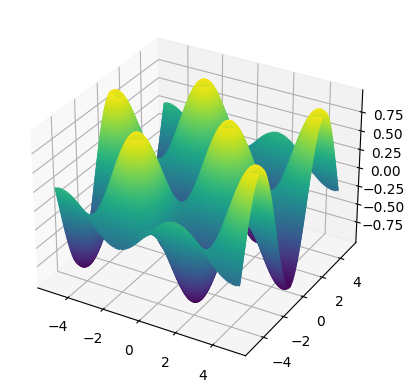

In [12]:
num_of_samples = 100
x_data = np.float64(np.linspace(-5, 5, num_of_samples))
y_data = np.float64(np.linspace(-5, 5, num_of_samples))

X, Y = np.meshgrid(x_data, y_data)
Z = np.sin(X)*np.cos(Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 200)
plt.show()

In [13]:
dataset = Dataset(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1), Z.reshape(-1, 1))
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

In [14]:
class Perceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

model = Perceptron(2, 100, 1)

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch: [1/10], loss: 0.3141
Epoch: [2/10], loss: 0.1587
Epoch: [3/10], loss: 0.2020
Epoch: [4/10], loss: 0.2328
Epoch: [5/10], loss: 0.2418
Epoch: [6/10], loss: 0.2498
Epoch: [7/10], loss: 0.1545
Epoch: [8/10], loss: 0.2714
Epoch: [9/10], loss: 0.1876
Epoch: [10/10], loss: 0.2094


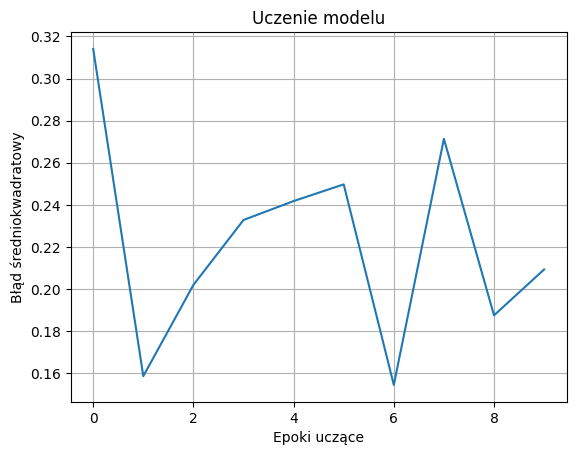

In [16]:
num_epochs = 100
all_losses = []
model.train()

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        x, y = x.reshape(-1, 2), y.reshape(-1, 1)
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
    all_losses.append(loss.item())
    print(f'Epoch: [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}')

plt.plot(all_losses)
# plt.yscale('log')
plt.title('Uczenie modelu')
plt.xlabel('Epoki uczące')
plt.ylabel('Błąd średniokwadratowy')
plt.grid()
plt.show()

Train error: 0.18312952022365328
Test error: 0.20320734599472837


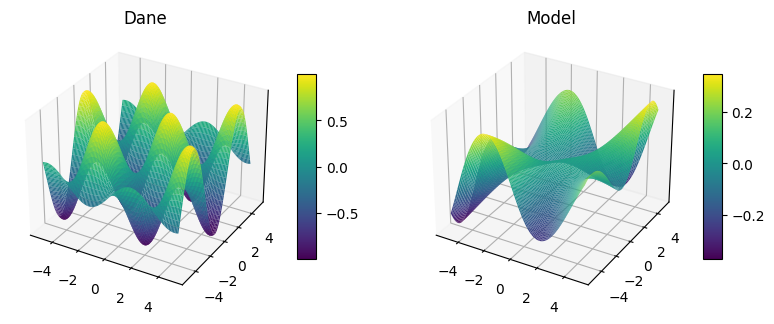

In [17]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 2))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 2))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
X, Y = np.meshgrid(x_data, y_data)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis')
ax.set_zticks([])
ax.set_title('Dane')
fig.colorbar(surf, shrink=0.5, aspect=10)

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1)).detach().numpy().reshape(num_of_samples, num_of_samples), rstride=1, cstride=1, cmap='viridis')
ax.set_zticks([])
ax.set_title('Model')
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

In [18]:
import plotly.graph_objects as go

predictions = model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1)).detach().numpy().reshape(-1)
trace1 = go.Scatter3d(
    x=X.reshape(-1),
    y=Y.reshape(-1),
    z=Z.reshape(-1)-predictions,
    mode='markers',
    marker=dict(
        size=2,
        color=Z.reshape(-1) - predictions,
        colorscale='Viridis',
        colorbar=dict(title='Data - predicitions'),
    ), name='Model')

fig = go.Figure(data=[trace1], layout=dict(width=700, height=500))
fig.update_layout(
    scene = dict(
        xaxis = dict(range=[-5,5]),
        yaxis = dict(range=[-5,5]),
        ),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10)
)
fig.show()

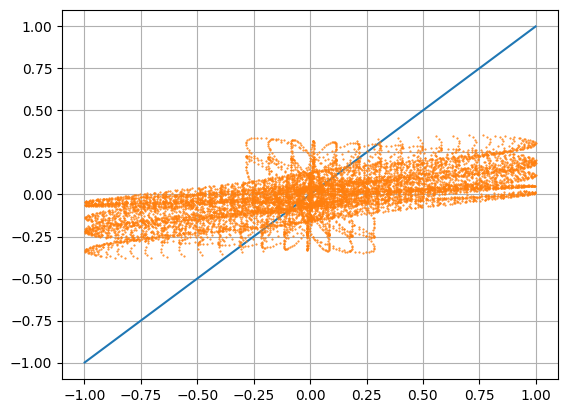

In [19]:
plt.plot([np.min(Z), np.max(Z)], [np.min(Z), np.max(Z)])
plt.plot(Z.reshape(-1), model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1)).detach().numpy().reshape(-1), '.', markersize=1)
plt.grid()
plt.show()